<a href="https://colab.research.google.com/github/Abhinaba35/Demand-Forecasting-Using-Time-Series-Analysis/blob/main/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

**Load Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load data
df = pd.read_csv("/content/drive/MyDrive/Retail_Dataset2.csv")

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


Mounted at /content/drive


**Aggregate to daily data**

In [3]:
daily_demand = df.groupby(df.index)['Order_Demand'].sum()
daily_demand = daily_demand.asfreq('D')

# Handle missing days
daily_demand = daily_demand.interpolate()


**Visualization**

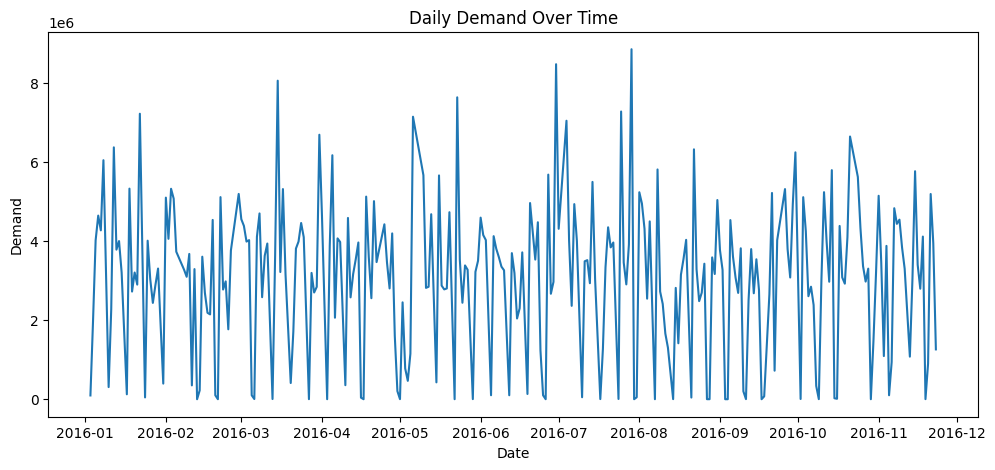

In [4]:
plt.figure(figsize=(12,5))
plt.plot(daily_demand)
plt.title("Daily Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()

**Seasonal Decomposition**

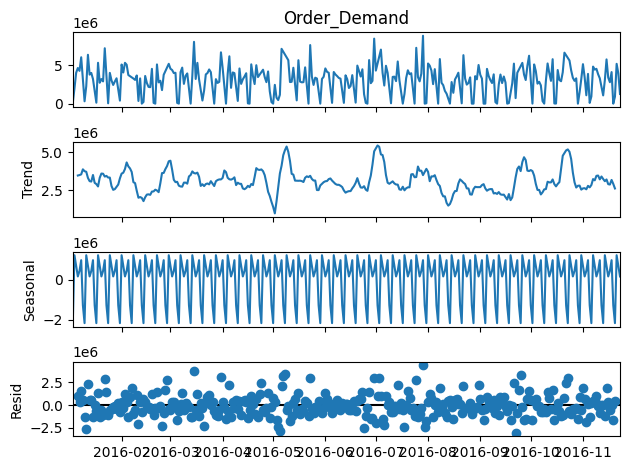

In [5]:
decomposition = seasonal_decompose(
    daily_demand,
    model='additive',
    period=7
)
decomposition.plot()
plt.show()

**Train-Test Split**

In [6]:
train_size = int(len(daily_demand) * 0.8)
train = daily_demand.iloc[:train_size]
test = daily_demand.iloc[train_size:]

**ARIMA Model**

In [7]:
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))


**Holt-Winters Model**

In [8]:
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=7
)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(len(test))


**Evaluation**

In [9]:
def evaluate_model(actual, predicted):
    actual = actual.values
    predicted = predicted.values

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    non_zero = actual != 0
    mape = np.mean(np.abs((actual[non_zero] - predicted[non_zero]) / actual[non_zero])) * 100

    return mae, rmse, mape

arima_metrics = evaluate_model(test, arima_forecast)
hw_metrics = evaluate_model(test, hw_forecast)

metrics_df = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [arima_metrics[0], hw_metrics[0]],
    "RMSE": [arima_metrics[1], hw_metrics[1]],
    "MAPE": [arima_metrics[2], hw_metrics[2]]
})

metrics_df

,Model,MAE,RMSE,MAPE
0,ARIMA,1.511848e+06,1.846429e+06,96008.671018
1,Exponential Smoothing,1.299568e+06,1.743525e+06,35942.268380


**Forecast Comparison Plot**

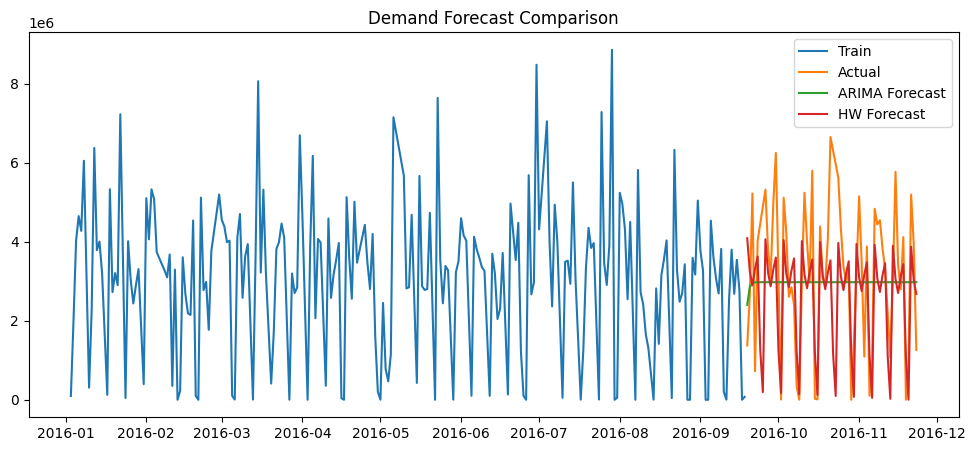

In [10]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, hw_forecast, label='HW Forecast')
plt.legend()
plt.title("Demand Forecast Comparison")
plt.show()


**Residual Analysis**

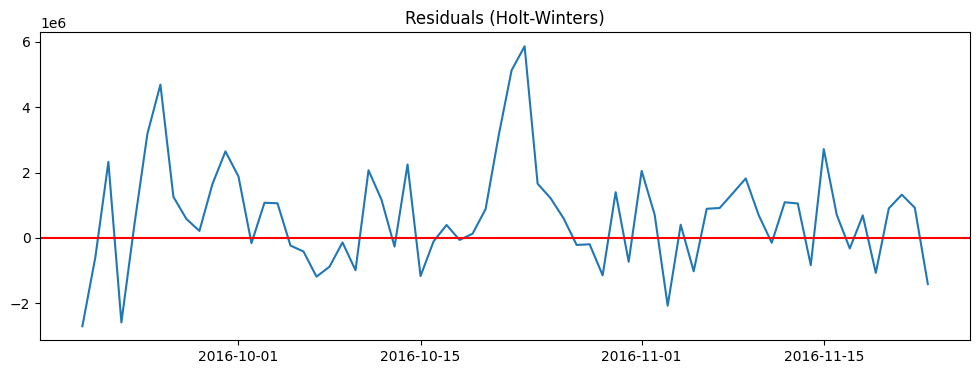

In [11]:
residuals = test - hw_forecast

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.axhline(0, color='red')
plt.title("Residuals (Holt-Winters)")
plt.show()


**Final Forecast**

In [12]:
final_model = ExponentialSmoothing(
    daily_demand,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()

future_forecast = final_model.forecast(12)
future_forecast


,0
2016-11-24,3.248110e+06
2016-11-25,4.013994e+06
2016-11-26,1.573007e+06
2016-11-27,8.121205e+05
2016-11-28,4.162688e+06
2016-11-29,3.769115e+06
2016-11-30,3.241216e+06
2016-12-01,3.237224e+06
2016-12-02,4.003108e+06
2016-12-03,1.562121e+06
